# Crear nuestro propio conjunto de datos

In [108]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.15,
    shear_range=5,
    zoom_range=[0.7, 1.3],
    validation_split=0.2
)

data_gen_entrenamiento = datagen.flow_from_directory(
    "dataset",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="training"
)

data_gen_pruebas = datagen.flow_from_directory(
    "dataset",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="validation",
)




Found 612 images belonging to 2 classes.
Found 152 images belonging to 2 classes.


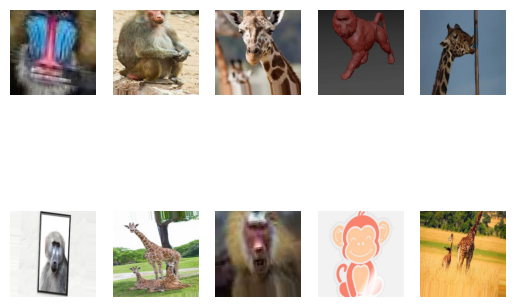

In [109]:
import matplotlib.pyplot as plt

for imagenes, etiquetas in data_gen_entrenamiento:
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(imagenes[i])  # Ojo: es `imagenes[i]`
        plt.axis('off')          # Quita los ejes para que se vea más limpio
    break  # Solo mostrar el primer batch
plt.show()

In [110]:
import tensorflow as tf
import tensorflow_hub as hub

# 1. Crear una capa Lambda que envuelva el KerasLayer
mobilenetv2 = tf.keras.layers.Lambda(
    lambda x: hub.KerasLayer(
        "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5",
        trainable=False
    )(x),
    input_shape=(224, 224, 3)
)

# 2. Ahora sí funciona en Sequential
modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(2, activation='softmax')
])

In [111]:
print("TensorFlow:", tf.__version__)  # Debe ser ≥ 2.10.0
print("TF Hub:", hub.__version__)    # Debe ser ≥ 0.13.0

TensorFlow: 2.19.0
TF Hub: 0.16.1


In [112]:
modelo.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [113]:
EPOCAS = 20

entrenamiento = modelo.fit(
    data_gen_entrenamiento,
    epochs=EPOCAS,
    batch_size=32,  # ¡Corregido!
    validation_data=data_gen_pruebas  # ¡Corregido!
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 332ms/step - accuracy: 0.7960 - loss: 0.4218 - val_accuracy: 0.9868 - val_loss: 0.0980
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.9371 - loss: 0.1336 - val_accuracy: 0.9934 - val_loss: 0.0556
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - accuracy: 0.9680 - loss: 0.0888 - val_accuracy: 0.9868 - val_loss: 0.0527
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - accuracy: 0.9766 - loss: 0.0663 - val_accuracy: 0.9803 - val_loss: 0.0497
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.9900 - loss: 0.0469 - val_accuracy: 0.9934 - val_loss: 0.0358
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - accuracy: 0.9900 - loss: 0.0406 - val_accuracy: 0.9934 - val_loss: 0.0316
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.9818 - loss: 0.0482 - val_accuracy: 0.9868 - val_loss: 0.0400
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - accuracy: 0.9915 - loss: 0.0378 - val_accuracy: 0.

In [118]:
from PIL import Image
import numpy as np
import cv2

def categorizar(ruta):
    # Corrección 1: Usa Image.open() en lugar de Image.opne()
    img = Image.open(ruta)  # <--- ¡Aquí estaba el error!
    
    # Corrección 2: Convertir la imagen abierta, no la clase Image
    img = img.convert("RGB")  # <--- img.convert() no Image.convert()
    
    # Convertir a array y normalizar
    img = np.array(img).astype(float)/255
    
    # Redimensionar (usando OpenCV como en tu versión original)
    img = cv2.resize(img, (224, 224))
    
    # Hacer la predicción
    prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))
    
    return np.argmax(prediccion[0], axis=-1)




In [119]:
# Ejemplo de uso
ruta = "/Users/richardmacairm1/Downloads/declive-de-la-jirafa.jpg"
prediccion = categorizar(ruta)
print("Clase predicha:", prediccion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
Clase predicha: 1


In [120]:
# Ejemplo de uso
ruta = "/Users/richardmacairm1/Documents/Proyectos Devolped/Leaning TensorFlow/dataset/babuino/463653.jpeg"
prediccion = categorizar(ruta)
print("Clase predicha:", prediccion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Clase predicha: 0


Primero identifica las imágenes problemáticas
Ejecuta este script para encontrar archivos corruptos:

In [98]:
import os
from PIL import Image
from pathlib import Path

def find_bad_images(data_dir):
    bad_files = []
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # Verifica integridad básica
                        img.convert('RGB')  # Intenta conversión a RGB
                except Exception as e:
                    bad_files.append((file_path, str(e)))
    return bad_files

# Ejecutar en ambos directorios
bad_train = find_bad_images('dataset/jirafa')
bad_val = find_bad_images('dataset/babuino')

print(f"Imágenes corruptas en entrenamiento: {len(bad_train)}")
print(f"Imágenes corruptas en validación: {len(bad_val)}")
for file, error in bad_train + bad_val:
    print(f"Problema en: {file}\nError: {error}\n")

Imágenes corruptas en entrenamiento: 383
Imágenes corruptas en validación: 382
Problema en: dataset/jirafa/250px-Giraffe_sticking_Tongue_out_to_eat_Carrot.jpg
Error: 'NoneType' object has no attribute 'seek'

Problema en: dataset/jirafa/tipos_de_jirafas_24573_orig.jpg
Error: 'NoneType' object has no attribute 'seek'

Problema en: dataset/jirafa/images (1).png
Error: 'NoneType' object has no attribute 'seek'

Problema en: dataset/jirafa/images (220).jpeg
Error: 'NoneType' object has no attribute 'seek'

Problema en: dataset/jirafa/images (265).jpeg
Error: 'NoneType' object has no attribute 'seek'

Problema en: dataset/jirafa/images (30).jpeg
Error: 'NoneType' object has no attribute 'seek'

Problema en: dataset/jirafa/images (199).jpeg
Error: 'NoneType' object has no attribute 'seek'

Problema en: dataset/jirafa/images (75).jpeg
Error: 'NoneType' object has no attribute 'seek'

Problema en: dataset/jirafa/images (121).jpeg
Error: 'NoneType' object has no attribute 'seek'

Problema en: d

Eliminación automática de imágenes corruptas
Ejecuta este script para limpiar tu dataset:

In [99]:
import os
from PIL import Image
from pathlib import Path

def clean_corrupt_images(directory):
    deleted = 0
    for img_path in Path(directory).rglob('*.*'):
        if img_path.suffix.lower() in ('.jpg', '.jpeg', '.png'):
            try:
                with Image.open(img_path) as img:
                    img.verify()
                # Verificación adicional de contenido
                if os.path.getsize(img_path) == 0:
                    raise ValueError("Archivo vacío")
            except Exception as e:
                print(f"Eliminando {img_path} - Error: {str(e)}")
                os.remove(img_path)
                deleted += 1
    return deleted

# Ejecuta en tus directorios
deleted_train = clean_corrupt_images('dataset/jirafa')
deleted_val = clean_corrupt_images('dataset/babuino')
print(f"Total eliminadas: {deleted_train + deleted_val}")

Eliminando dataset/jirafa/formas-de-jirafa-aislado-en-blanco.jpg - Error: cannot identify image file '/Users/richardmacairm1/Documents/Proyectos Devolped/Leaning TensorFlow/dataset/jirafa/formas-de-jirafa-aislado-en-blanco.jpg'
Total eliminadas: 1


Solución Alternativa para Archivos con Nombres Problemáticos:
Si el problema persiste por nombres de archivo con caracteres especiales o espacios:

In [ ]:
def rename_problematic_files(directory):
    renamed = 0
    for img_path in Path(directory).rglob('*.*'):
        if " " in img_path.name or "(" in img_path.name:
            new_name = img_path.name.replace(" ", "_").replace("(", "").replace(")", "")
            new_path = img_path.with_name(new_name)
            img_path.rename(new_path)
            renamed += 1
    return renamed

renamed_count = rename_problematic_files('dataset')
print(f"Archivos renombrados: {renamed_count}")